In [142]:
import pandas as pd
import seaborn as sns
import re

In [143]:

# Define the file path
scan_outside_1 = 'analysis/outside_recording/BaProj1_outside_scan_dump'
scan_outside_2 = 'analysis/outside_recording/BaProj2_outside_scan_dump'
scan_inside_1 = 'analysis/outside_recording/BaProj1_inside_scan_dump'
scan_inside_2 = 'analysis/outside_recording/BaProj2_inside_scan_dump'

file = scan_outside_2
# file = scan_inside_2

In [144]:
def read_scan_dump(file_path):
    # Define regex patterns to extract the required information
    patterns = {
        "mac_address": re.compile(
            r"([0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2})"
        ),
        "freq": re.compile(r"freq:\s+(\d+)"),
        "beacon_interval": re.compile(r"beacon interval:\s+(\d+)"),
        "signal": re.compile(r"signal:\s+(-?\d+\.\d+) dBm"),
        "last_seen": re.compile(r"last seen:\s+(\d+) ms ago"),
        "SSID": re.compile(r"SSID: +([^\n]*)\n"),
        "DS_Parameter_set": re.compile(r"DS Parameter set:\s+channel (\d+)"),
        "HT_operation": re.compile(r"HT operation:\n((?:\s+\* .+\n)+)"),
    }
    # Initialize lists to store the extracted data
    data = []

    # Read the file and extract the data
    with open(file_path, "r") as file:
        content = file.read()
        bss_blocks = re.split(r"^BSS ", content, flags=re.MULTILINE)[
            1:
        ]  # first split element is empty

        for block in bss_blocks:
            bss_data = {}
            for key, pattern in patterns.items():
                match = pattern.search(block)
                if match:
                    if key == "HT_operation":
                        ht_operation_data = match.group(1).strip().split("\n")
                        for item in ht_operation_data:
                            k, v = item.strip().split(": ", 1)
                            k = k.lstrip("* ")
                            bss_data[k.strip()] = v.strip()
                    else:
                        bss_data[key] = match.group(1).strip()
            data.append(bss_data)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    df = df.apply(pd.to_numeric, errors="ignore")
    return df

In [145]:
df = read_scan_dump(file)

complete = pd.concat([read_scan_dump(scan_inside_2),  read_scan_dump(scan_outside_2)])
complete['RSSI'] = complete['signal'].apply(lambda x: 2 * (x + 100))
channels = complete["DS_Parameter_set"]

# colors = sns.color_palette(palette='bright', n_colors=channels.nunique())
# colors = dict(zip(channels.unique(), colors))

# colors[6] = sns.color_palette(palette='bright', n_colors=channels.nunique())[-1]

colors = [
'#1b9e77',
'#d95f02',
'#7570b3',
'#e7298a',
'#66a61e',
'#e6ab02',
]
color_dict = dict(zip(channels.unique(), colors))


/tmp/ipykernel_85647/4115435611.py:43: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot = sns.barplot(data=df, x='DS_Parameter_set', y='signal', hue='mac_address')
# Convert signal data from dBm to RSSI
df['RSSI'] = df['signal'].apply(lambda x: 2 * (x + 100))  # Conversion Formula Microsoft

empty_count = 0
def generate_empty_ssid(x):
    global empty_count
    if x == '':
        empty_count += 1
        return f'HIDDEN_{empty_count}'
    return x
df['SSID'] = df['SSID'].apply(lambda x: generate_empty_ssid(x) if x == '' else x)



In [147]:
ssid_unique = df['SSID'].unique()
len(ssid_unique)

15

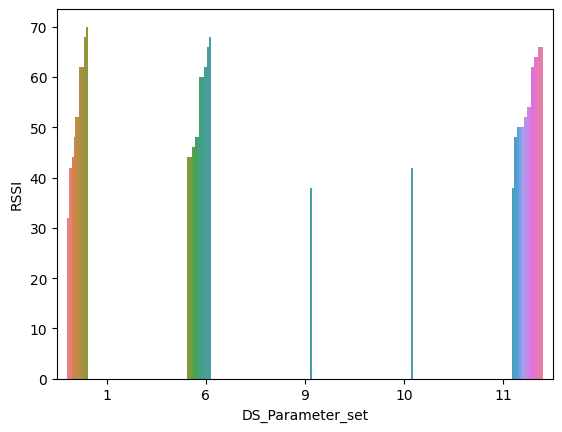

In [148]:
df.sort_values(by='RSSI', ascending=True, inplace=True)
plot = sns.barplot(data=df, x='DS_Parameter_set', y='RSSI', hue='mac_address', legend=False)
# plot.set_xlim(0, 14)
# plt.gca().invert_yaxis()
# plt.show()

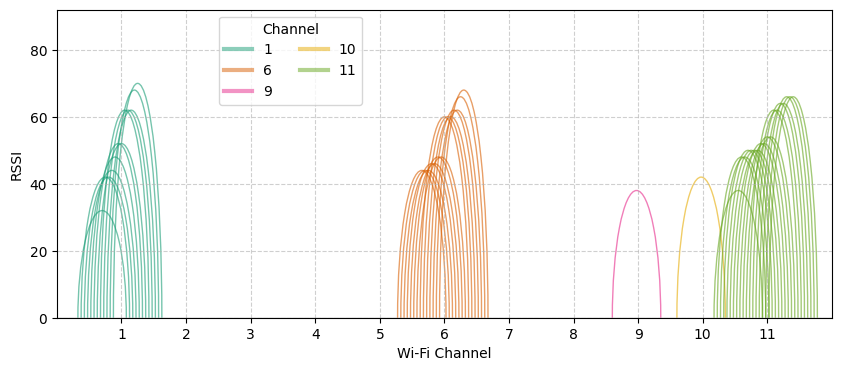

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Arc
from collections import defaultdict
import os.path

df.sort_values(by=['DS_Parameter_set', 'RSSI'], inplace=True, ascending=True)

channels = df['DS_Parameter_set']  # Example Wi-Fi channels
signal_strengths = df['RSSI'].to_list()  # Example signal strengths (dBm)
# ssid = df['SSID'].to_list()
ssid_unique


# palette = sns.color_palette("husl", len(ssid_unique))  # Generate a color palette
# hex_palette = [sns.utils.rgb2hex(color) for color in palette]  # Convert to hex format
# colors = {ssid: color for ssid, color in zip(ssid_unique, palette)}  # Create a color dictionary

offset = 0.05  # Offset value for each repeated occurrence
x_offsets = defaultdict(int)  # Track the number of occurrences for each x-value
channel_dithered = []

for value in channels:
    channel_dithered.append(value + (x_offsets[value] * offset))
    x_offsets[value] += 1

# center the dithered values
for idx, channel in enumerate(channels):
    channel_dithered[idx] = channel_dithered[idx] - (x_offsets[channel] * offset) / 2
    


# Function to draw half-ellipse
def add_half_ellipse(ax, x, y, width, height, color):
    arc = Arc((x, y), width, height*2, angle=0, theta1=0, theta2=180, color=color, alpha=0.6)
    ax.add_patch(arc)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(0, color='black', linewidth=0.8)  # x-axis baseline

# Add half-ellipses to the plot
for i, (channel, strength) in enumerate(zip(channel_dithered, signal_strengths)):
    # ssid = df['SSID'].iloc[i]
    # color = palette[np.where(ssid_unique == ssid)[0][0]]
    # add_half_ellipse(ax, channel, 0, width=0.8, height=strength, color=colors[ssid])
    add_half_ellipse(ax, channel, 0, width=0.75, height=strength, color=color_dict[df['DS_Parameter_set'].iloc[i]])

# Customize plot
ax.set_xlim(0, max(channels) + 1)
ax.set_ylim(0, max(complete['RSSI']) + 10)
ax.set_xlabel("Wi-Fi Channel")
ax.set_ylabel("RSSI")
# ax.set_title("Wi-Fi Network Signal Strength")
ax.grid(True, linestyle='--', alpha=0.6)

plt.xticks(ticks=np.arange(1, 12, 1), labels=np.arange(1, 12, 1))  # ticks and labels are the same here
# Create the legend using the color dictionary
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
#            for color in colors.values()]

# # Add the legend with the labels from the dictionary
# ax.legend(handles=handles, labels=colors.keys(), title="Networks")

# create a legend
legend_lines = [plt.Line2D([0], [0], color=color_dict[channel], alpha=0.5, lw=3, label=channel) for channel in channels.unique()]
legend = ax.legend(title='Channel', loc='upper left', handles=legend_lines, ncol=2, bbox_to_anchor=(0.2, 1))
# set legend position



# Adjust plot aspect ratio for better visualization
# ax.set_aspect('auto')
plt.savefig(f'plots/wifi_strength_{os.path.basename(file)}.svg', bbox_inches='tight', dpi=600)
plt.show()